In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
from matplotlib.ticker import ScalarFormatter



/afs/cern.ch/work/a/aradosla/private/miniforge3/lib/python3.10/site-packages/xtrack/progress_indicator.py:95: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
collider = xt.Multiline.from_json('collider/collider.json')
collider.build_trackers()

Loading line from dict: 100%|██████████| 80692/80692 [00:03<00:00, 22733.80it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 80836/80836 [00:03<00:00, 24030.85it/s]


Done loading line from dict.           


Loading line from dict:  89%|████████▉ | 71708/80692 [00:02<00:00, 26539.63it/s]

In [ ]:
line = collider['lhcb1']

In [ ]:
ctx = xo.ContextCpu()
N_particles = 10000
bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2 
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = collider['lhcb1'])



*** Maximum RMS bunch length 0.11789515107786017m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4969e-02
... distance to target bunch length: 8.3249e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3353e-04
... distance to target bunch length: -2.3602e-05
... distance to target bunch length: 1.8476e-07
... distance to target bunch length: -1.8173e-07
--> Bunch length: 0.0749998182688671
--> Emittance: 1.8429193446948005


In [5]:
gaussian_bunch.x

array([-2.48762603e-04,  2.30770273e-04, -4.14821320e-04, ...,
       -1.60301314e-04, -1.32731030e-04,  7.40169838e-05])

In [6]:
# Convert the bunch data to a DataFrame
# Convert the bunch data to a dictionary


pd.DataFrame(gaussian_bunch.to_dict()).to_parquet("input_particles.parquet")

gaus = pd.read_parquet('input_particles.parquet')


In [7]:
# Import the parquet gaussian bunch
N_turns = 100
#gaus = pd.read_parquet('gaussian_bunch.parquet')
#line.track(gaus,  num_turns = N_turns, turn_by_turn_monitor=True, freeze_longitudinal=True)

Text(0.5, 1.0, 'Closed orbit')

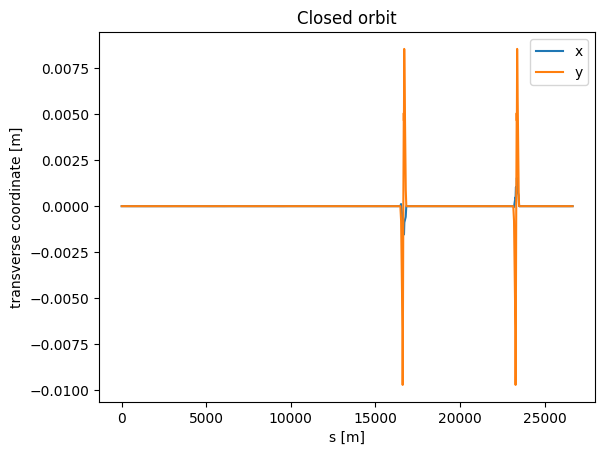

In [8]:
tw0 = collider.lhcb1.twiss()
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])

fig, ax = plt.subplots()
plt.plot(tw0.s, tw0.x, label='x')
plt.plot(tw0.s, tw0.y, label='y')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('transverse coordinate [m]')
plt.title('Closed orbit')

In [9]:

line.track(gaussian_bunch, num_turns = N_turns, turn_by_turn_monitor=True, freeze_longitudinal=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [10]:
def build_particle_distribution(gaussian_bunch1x, gaussian_bunch1y):
    # Define radius distribution
    #r_min = config_particles["r_min"]
    #r_max = config_particles["r_max"]
    #n_r = config_particles["n_r"]
    #radial_list = np.linspace(r_min, r_max, n_r, endpoint=False)

    # Filter out particles with low and high amplitude to accelerate simulation
    # radial_list = radial_list[(radial_list >= 4.5) & (radial_list <= 7.5)]

    # Define angle distribution
    #n_angles = config_particles["n_angles"]
    #theta_list = np.linspace(0, 90, n_angles + 2)[1:-1]

    # Define particle distribution as a cartesian product of the above
    particle_list = [
        (particle_id, y, x)
        for particle_id, x, y in zip(range(len(gaussian_bunch1x)), gaussian_bunch1x, gaussian_bunch1y)
    ]
    
    # Split distribution into several chunks for parallelization
    n_split = 1
    particle_list = list(np.array_split(particle_list, n_split))

    # Return distribution
    return particle_list

In [11]:
part = build_particle_distribution(gaussian_bunch.x, gaussian_bunch.y)

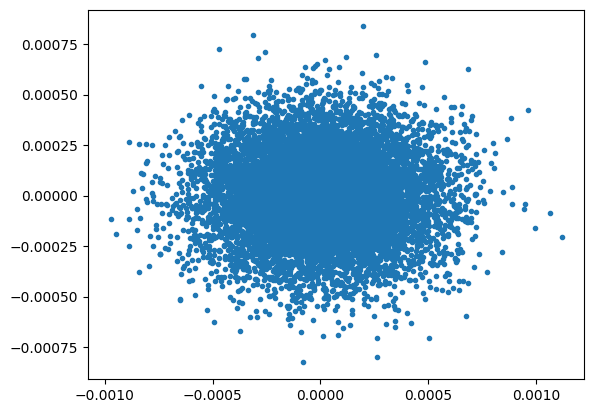

In [12]:
plt.plot(np.array(part).T[:][1], np.array(part).T[:][2], '.')